In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as scq
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import numpy as np

np.set_printoptions(threshold=10, edgeitems=2)

# Define HilbertSpace object: two transmons coupled to an oscillator


tmon1 = scq.TunableTransmon(
    EJmax=40.0,
    EC=0.2,
    d=0.1,
    flux=0.23,
    ng=0.3,
    ncut=40,
    truncated_dim=3,     # after diagonalization, we will keep 3 levels
    id_str="tmon1"       # optional, used for referencing from within
                         # ParameterSweep or HilbertSpace
)

tmon2 = scq.TunableTransmon(
    EJmax=15.0,
    EC=0.15,
    d=0.2,
    flux=0.0,
    ng=0.0,
    ncut=30,
    truncated_dim=3,
    id_str="tmon2"
)

resonator = scq.Oscillator(
    E_osc=4.5,
    truncated_dim=4    # up to 3 photons (0,1,2,3)
)

hilbertspace = scq.HilbertSpace([tmon1, tmon2, resonator])


g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

hilbertspace.add_interaction(
    g_strength = g1,
    op1 = tmon1.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True,
    id_str="tmon1-resonator"  # optional keyword argument
)

hilbertspace.add_interaction(
    g_strength = g2,
    op1 = tmon2.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True,
    id_str="tmon2-resonator"  # optional keyword argument
)

# Set up parameter name and values
pname1 = 'flux'  
flux_vals = np.linspace(0.0, 2.0, 171)
pname2 = 'ng'
ng_vals = np.linspace(-0.5, 0.5, 49)

# combine into a dictionary
paramvals_by_name = {pname1: flux_vals, pname2: ng_vals}


area_ratio = 1.2

def update_hilbertspace(flux, ng):  # function that defines how Hilbert space components are updated
    tmon1.flux = flux
    tmon2.flux = area_ratio * flux
    tmon2.ng = ng

# dictionary with information on which subsystems are affected by changing parameters    
subsys_update_info = {pname1: [tmon1, tmon2],
                      pname2: [tmon2]}

    
# create the ParameterSweep    
sweep = ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=20,
    subsys_update_info=subsys_update_info,
    num_cpus=4
)

Parallel compute bare eigensys for subsystem tmon1 [num_cpus=4]

Parallel compute bare eigensys for subsystem tmon2 [num_cpus=4]

Parallel compute bare eigensys for subsystem Oscillator_1 [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

## Custom sweeps
`ParameterSweep` generates data commonly needed in a multi-component quantum system. Other quantities of interest can be generated by defining a custom sweep function generating the data and calling `<ParameterSweep>.add_sweep(...)`.

To do so, define a function of the following form:

``def custom_func(paramsweep, paramindex_tuple, paramvals_tuple, **kwargs):
    ...
    return data``
    
As a toy example, here is a function that returns the 01 charge matrix element for `tmon2` at each parameter point:

In [2]:
def tmon2_n01(paramsweep, paramindex_tuple, paramvals_tuple, **kwargs):
    # We could recalculate matrix elements from scratch, but it is advantageous to use the bare spectral 
    # data we have already calculated.
    bare_evecs = paramsweep["bare_evecs"]["subsys":1][paramindex_tuple]
    n_matrix_elements = tmon2.matrixelement_table(
        operator="n_operator",
        evecs=bare_evecs,
        evals_count=tmon2.truncated_dim,
    )
    return np.abs(n_matrix_elements[0,1])

The `add_sweep` method takes the callable function one argument, and the name under which the scan should be stored as the second argument:

In [3]:
sweep[:].add_sweep(tmon2_n01, "n01")

sweeping tmon2_n01:   0%|          | 0/8379 [00:00<?, ?it/s]

Pre-slicing is required; here the sweep is to extend over all parameter sets associated with sweep. The resulting data is accessible by dict-like access, and yields a `NamedSlotsNdarray`:

In [4]:
sweep["n01"]

NamedSlotsNdarray([[1.30478755, 1.30478755, ..., 1.30478755, 1.30478755],
                   [1.30446711, 1.30446711, ..., 1.30446711, 1.30446711],
                   ...,
                   [1.02349545, 1.02349545, ..., 1.02349545, 1.02349545],
                   [0.99863368, 0.99863367, ..., 0.99863367, 0.99863368]])

We can easily take a slice for fixed flux and plot the result:

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='ng'>)

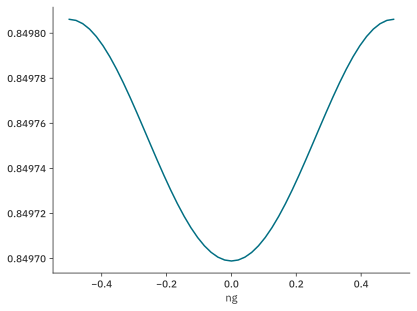

In [5]:
sweep["n01"]["flux":35].plot()